# Linear Optimal Transport 

Let $[p_i]_{i=1}^M$ be probability distributions, and let $X_i=[x^i_k\in \mathbb{R}^d \sim p_i]_{k=1}^{N_i}\in \mathbb{R}^{N_i\times d}$ be the set of $N_i$ samples from distribution $p_i$. Let us define $p_0$ to be a template distribution, with $X_0=[x^0_k\in \mathbb{R}^d \sim p_0]_{k=1}^{N}$, where $N=\lfloor \frac{1}{M}\sum_{i=1}^M N_i \rfloor$. 

## Optimal Transport - Kantorovich Formulation

The transport plan between $p_i$ and $p_0$ is calculated from solving the following linear program:

$$ \pi^* = \operatorname{argmin}_{\pi} \sum_{k=1}^{N}\sum_{l=1}^{N_i} \pi_{kl}\| x^0_k - x^i_l \|^2 $$ 

$$ s.t. \sum_{k} \pi_{kl}=\frac{1}{N_i}~,~\sum_{l} \pi_{kl}=\frac{1}{N} $$

where $\pi^*\in \mathbb{R}^{N\times N_i}$. The transport map is obtained via: $F_i= N(\pi^* X_i)\in \mathbb{R}^{M\times d}$ and we define the transport displacement to be $V_i=F_i-X_0$. 

Given $X_0$, $V_i$ "uniquely" identifies $X_i$. The mapping from $X_i$ to $V_i$ is what we denote as a Transport-Based Transform, and below we demonstrate its nonlinear characteristics. 

## Walkthrough

In [1]:
import numpy as np
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ot

Let us first generate a dataset of $p_i$s (or better to say $X_i$s). We generate a list of $X_i$s and name the list $X$.

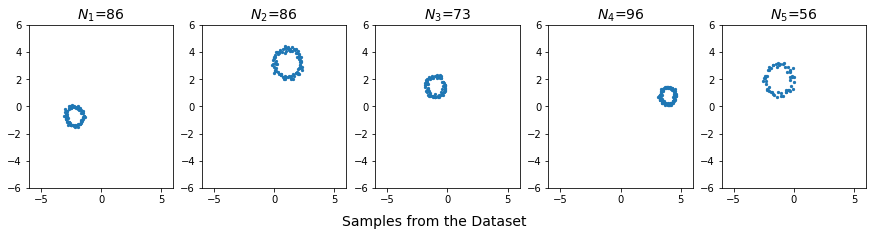

In [2]:
M=100 # Number of data samples
X=list()
for i in range(M):
    data,y=make_circles(n_samples=int(50*np.random.rand()+50),noise=.1,factor=.95)
    data=(np.random.rand()+.5)*data+2*np.random.randn(1,2)
    X.append(data)

k=5
fig,ax=plt.subplots(1,k,figsize=(k*3,3))
for i in range(k):
    ax[i].scatter(X[i][:,0],X[i][:,1],s=5)
    ax[i].set_title(r'$N_%d$=%d'%(i+1,X[i].shape[0]),fontsize=14)
    ax[i].set_xlim(-6,6)
    ax[i].set_ylim(-6,6)
fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
plt.show()

Now, let us define our template to be the normal distribution and sample it at $N=\lfloor\frac{1}{M} \sum_{i=1}^M N_i \rfloor$, to obtain $X0$.

Text(0.5, 1.0, 'Template')

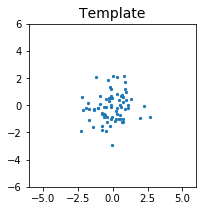

In [3]:
N=int(np.asarray([x.shape[0] for x in X]).mean())
X0=np.random.randn(N,2)

fig=plt.figure(figsize=(3,3))
plt.scatter(X0[:,0],X0[:,1],s=5)
plt.xlim((-6,6))
plt.ylim((-6,6))
plt.title('Template',fontsize=14)

Here we calculate the transport plan and the approximated transport map by solving the Kantorovich problem. Then we visualize the geodesic between $p_i$ and $p_0$ via: 

$$ X_i^\alpha = X_0+\alpha V_i $$

for $\alpha \in [0,1]$.

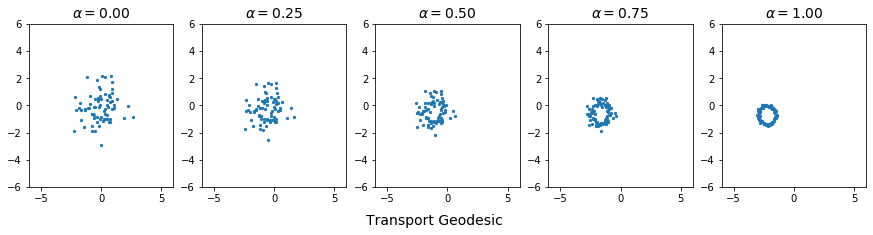

In [4]:
ind=0

Ni=X[ind].shape[0]
C=ot.dist(X[ind],X0)
b=np.ones((N,))/float(N)
a=np.ones((Ni,))/float(Ni)
p=ot.emd(a,b,C) # exact linear program

Vi=np.matmul((N*p).T,X[ind])-X0

k=5
fig,ax=plt.subplots(1,k,figsize=(k*3,3))
# ax[k-1].scatter(X[ind][:,0],X[ind][:,1],c='r',s=20)
for i,alpha in enumerate(np.linspace(0,1,k)):
    samples=X0+alpha*Vi
    ax[i].scatter(samples[:,0],samples[:,1],s=5)
    ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
    ax[i].set_xlim(-6,6)
    ax[i].set_ylim(-6,6)

fig.text(0.5, -0.05, 'Transport Geodesic', ha='center',fontsize=14)
plt.show()

Now we calculate $V_i$s for the entire dataset, and put them in an array (because $V_i\in\mathbb{R}^{N\times d}~$).

In [5]:
V=list()
for ind in range(M):
    Ni=X[ind].shape[0]
    C=ot.dist(X[ind],X0)
    b=np.ones((N,))/float(N)
    a=np.ones((Ni,))/float(Ni)
    p=ot.emd(a,b,C) # exact linear program
    V.append(np.matmul((N*p).T,X[ind])-X0)
V=np.asarray(V)

Now we calculate the mean of the dataset in the transpor-space as:

$$ \bar{V}= \frac{1}{M}\sum_{i=1}^M V_i $$

and we can visualize the mean via: 

$$ \bar{X}= X_0+\bar{V} $$

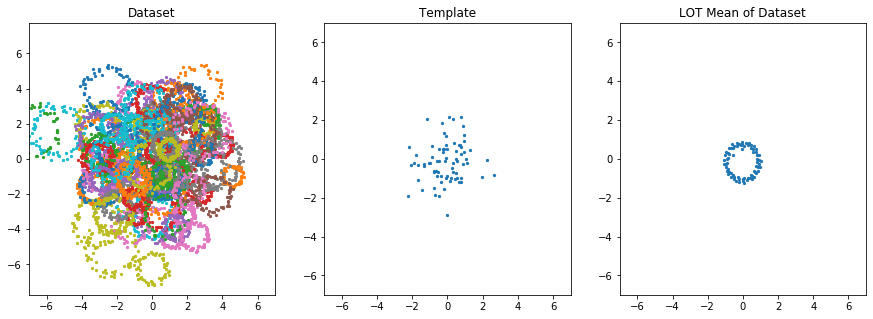

In [6]:
vmean=V.mean(0)
fig,ax=plt.subplots(1,3,figsize=(15,5))
for Xi in X:
    ax[0].scatter(Xi[:,0],Xi[:,1],s=5)    
ax[0].axis('equal')
ax[0].set_title('Dataset')
ax[1].scatter(X0[:,0],X0[:,1],s=5)
ax[1].set_title('Template')
ax[2].scatter((X0+vmean)[:,0],(X0+vmean)[:,1],s=5)
ax[2].set_title('LOT Mean of Dataset')
for i in range(3):
    ax[i].set_xlim(-7,7)
    ax[i].set_ylim(-7,7)
plt.show()

Finally, we can visualize the variations in the dataset via PCA on the transport maps.

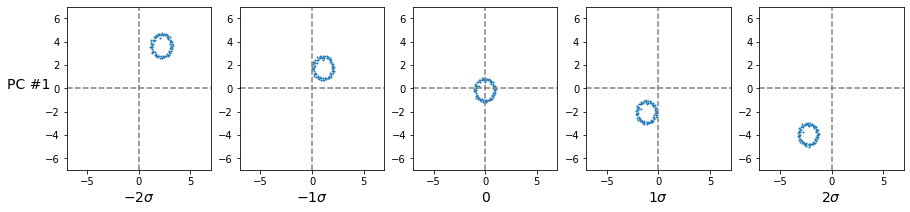

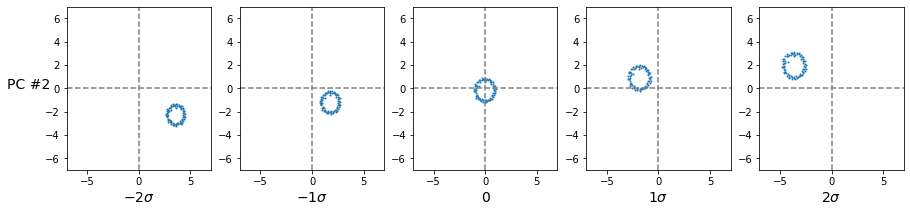

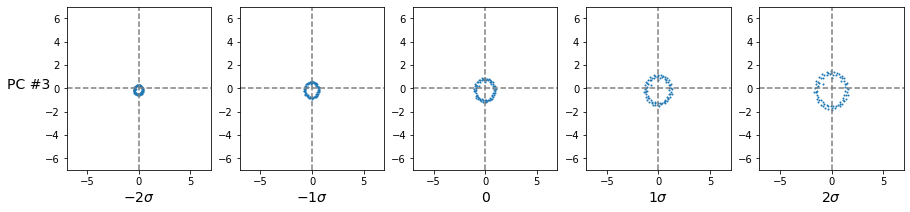

In [7]:
npca=3
pca=PCA(n_components=npca)
pca_proj=pca.fit_transform(V.reshape(M,-1))
stds = np.std(pca_proj,0)
for i,vpca in enumerate(pca.components_):
    Vpca=vpca.reshape(N,2)    
    fig,ax=plt.subplots(1,5,figsize=(15,3))    
    for k,tau in enumerate(np.linspace(-2,2,5)):
        samples=X0+vmean+tau*stds[i]*Vpca
        ax[k].plot(np.zeros((5,)),np.linspace(-7,7,5),'--',c='gray')
        ax[k].plot(np.linspace(-7,7,5),np.zeros((5,)),'--',c='gray')
        ax[k].scatter(samples[:,0],samples[:,1],s=1)
        if tau==0:
            ax[k].set_xlabel('0',fontsize=14)
        else:
            ax[k].set_xlabel(r'$%d\sigma$'%tau,fontsize=14)
        ax[k].set_xlim(-7,7)
        ax[k].set_ylim(-7,7)        
    fig.text(0.09, 0.5, 'PC #%d'%(i+1), ha='center',fontsize=14)
    plt.show()

As can be seen, the principle components capture the translations and dilation in the dataset.